# <center>Convolution Neural Networks</center>

<center>Shan-Hung Wu & DataLab <br>Fall 2023</center>

In this lab, we introduce two datasets, **MNIST** and **CIFAR**, then we will talk about how to implement CNN models for these two datasets using tensorflow. The major difference between mnist and cifar is their size. Due to the limit of memory size and time issue, we offer a guide to illustrate typical **input pipeline** of tensorflow. Let's dive into tensorflow!

In [2]:
import warnings
import os
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import matplotlib.pyplot as plt
import numpy as np


import matplotlib as mpl
import pickle
import csv
import itertools
from collections import defaultdict
import time
import pandas as pd
import math
from tqdm import tqdm
import dill

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 1 Logical GPUs


In [4]:
import urllib.request
if not os.path.exists("lab11_1_lib.py"):
    urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/11-1_CNN/lab11_1_lib.py", "lab11_1_lib.py")

from lab11_1_lib import draw_timeline

## MNIST

We start from a simple dataset. MNIST is a simple computer vision dataset. It consists of image of handwritten digits like:

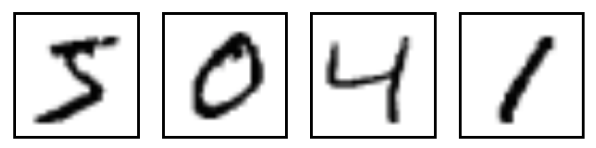

It also includes label for each image, telling us which digit it is. For example, the label for the above image are 5, 0, 4, and 1. Each image is 28 pixels by 28 pixels. We can interpret this as a big array of numbers:

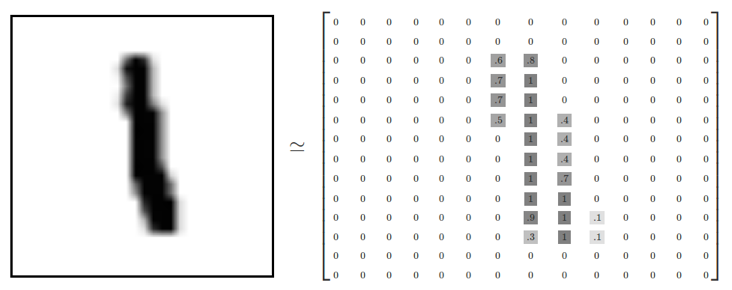

The MNIST data is hosted on [Yann LeCun's website](http://yann.lecun.com/exdb/mnist/). We can directly import MNIST dataset from Tensorflow.

In [5]:
# Download and prepare the MNIST dataset
(train_image, train_label), (test_image, test_label) = datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_image, test_image = train_image / 255.0, test_image / 255.0
print('shape of train_image:', train_image.shape)
print('shape of train_label:', train_label.shape)

shape of train_image: (60000, 28, 28)
shape of train_label: (60000,)


### Softmax Regression on MNIST

Before jumping to Convolutional Neural Network model, we're going to start with a very simple model with a single layer and softmax regression.

We know that every image in MNIST is a handwritten digit between zero and nine. So there are only ten possible digits that a given image can be. We want to give the probability of the input image for being each digit. That is, input an image, the model outputs a ten-dimension vector.

This is a classic case where a softmax regression is a natural, simple model. If you want to assign probabilities to an object being one of several different things, softmax is the thing to do.

In [6]:
# flating the training data for dense layers
train_image_1 = train_image.reshape((60000, -1))
test_image_1 = test_image.reshape((10000, -1))
print(train_image_1.shape)
print(test_image_1.shape)

(60000, 784)
(10000, 784)


In [7]:
model_1 = models.Sequential()
model_1.add(layers.Dense(10, activation='softmax',input_shape=(784,)))
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# compile the model and train it for 5 epochs
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_1.fit(train_image_1, train_label, epochs=5)

Epoch 1/5
 859/1875 [============>.................] - ETA: 1s - loss: 0.6101 - accuracy: 0.8472

1875/1875 [==============================] - 3s 985us/step - loss: 0.4675 - accuracy: 0.8781
Epoch 2/5
1875/1875 [==============================] - 2s 967us/step - loss: 0.3041 - accuracy: 0.9153
Epoch 3/5
1875/1875 [==============================] - 2s 948us/step - loss: 0.2834 - accuracy: 0.9211
Epoch 4/5
1875/1875 [==============================] - 2s 945us/step - loss: 0.2732 - accuracy: 0.9232
Epoch 5/5
1875/1875 [==============================] - 2s 960us/step - loss: 0.2669 - accuracy: 0.9262


In [9]:
_, test_acc_1 = model_1.evaluate(test_image_1, test_label, verbose=0)
print('Testing Accuracy : %.4f'%test_acc_1)

Testing Accuracy : 0.9259


From the above result, we got about 92% accuracy for Softmax Regression on MNIST. In fact, it's not so good. This is because we're using a very simple model.

### Multilayer Convolutional Network on MNIST

We're now jumping from a very simple model to something moderately sophisticated: a small Convolutional Neural Network. This will get us to over 99% accuracy, not state of the art, but respectable.

In [10]:
# reshaping the training data to 3 dimensions
train_image_2 = train_image.reshape((60000, 28, 28, 1))
test_image_2 = test_image.reshape((10000, 28, 28, 1))
print(train_image_2.shape)
print(test_image_2.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


##### Create the convolutional base

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to color channels, MNIST has one (because the image are grayscale), whereas a color image has three (R,G,B). In this example, we will configure our CNN to process inputs of shape (28, 28, 1), which is the format of MNIST image. We do this by passing the argument **input_shape** to our first layer.

In [11]:
#The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='valid', activation='relu', input_shape=(28, 28, 1)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='valid', activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='valid', activation='relu'))

Let's display the architecture of our model so far.

In [12]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55744 (217.75 KB)
Trainable params: 5574

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, we can afford (computationally) to add more output channels in each Conv2D layer.

##### Add Dense layers on top

To complete our model, we will feed the last output tensor from the convolutional base (of shape (3, 3, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, we will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. MNIST has 10 output classes, so we use a final Dense layer with 10 outputs and a softmax activation.

To reduce overfitting, we will apply dropout before the readout layer. The idea behind dropout is to train an ensemble of model instead of a single model. During training, we drop out neurons with probability $p$, i.e., the probability to keep is $1-p$. When a neuron is dropped, its output is set to zero. These dropped neurons do not contribute to the training phase in forward pass and backward pass. For each training phase, we train the network slightly different from the previous one. It's just like we train different networks in each training phrase. However, during testing phase, we **don't** drop any neuron, and thus, implement dropout is kind of like doing ensemble. Also, randomly drop units in training phase can prevent units from co-adapting too much. Thus, dropout is a powerful regularization techique to deal with overfitting.

In [13]:
model_2.add(layers.Flatten())
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(10, activation='softmax'))

Here's the complete architecture of our model.

In [14]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)              

As you can see, our (3, 3, 64) outputs were flattened into vectors of shape (576) before going through two Dense layers.

##### Compile and train the model

In [15]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_2.fit(train_image_2, train_label, epochs=5)

Epoch 1/5


1875/1875 [==============================] - 5s 2ms/step - loss: 0.2659 - accuracy: 0.9190
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0925 - accuracy: 0.9746
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0670 - accuracy: 0.9814
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0493 - accuracy: 0.9858
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0473 - accuracy: 0.9869


In [16]:
_, test_acc_2 = model_2.evaluate(test_image_2, test_label, verbose=0)
print('Testing Accuracy : %.4f'%test_acc_2)

Testing Accuracy : 0.9934


As you can see, our simple CNN has achieved a test accuracy of 99%. Not bad for a few lines of code! For another style of writing a CNN (using the Keras Subclassing API and a GradientTape) head [here](https://www.tensorflow.org/tutorials/quickstart/advanced).

## Cifar-10

Actually MNIST is a easy dataset for the beginner. To demonstrate the power of Neural Networks, we need a larger dataset CIFAR-10.

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 color image in 10 classes, with 6000 image per class. There are 50000 training image and 10000 test image. Here are the classes in the dataset, as well as 10 random image from each:

![CIFAR10.png](/home/s111062697/deep_learning/lecture11/tutorial/CIFAR10.png)

Before jumping to a complicated neural network model, we're going to start with **KNN** and **SVM**. The motivation here is to compare neural network model with traditional classifiers, and highlight the performance of neural network model.

tf.keras.datasets offers convenient facilities that automatically access some well-known datasets. Let's load the CIFAR-10 in tf.keras.datasets:

In [17]:
# Loading Data

(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# convert class vectors to binary vectors
Y_train = utils.to_categorical(y_train)
Y_test = utils.to_categorical(y_test)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


For simplicity, we also convert the image into the grayscale. We use the [Luma coding](https://en.wikipedia.org/wiki/Grayscale#Luma_coding_in_video_systems) that is common in video systems:

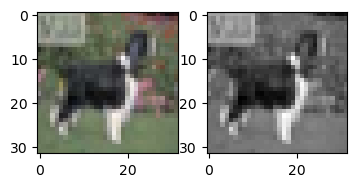

In [18]:
# transform a 3-channel image into one channel
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r = np.asarray(.3, dtype=dtype)
    g = np.asarray(.59, dtype=dtype)
    b = np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

X_train_gray = grayscale(X_train)
X_test_gray = grayscale(X_test)

# plot a randomly chosen image
img = round(np.random.rand() * X_train.shape[0])
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(X_train[img], interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(
    X_train_gray[img, :, :, 0], cmap=plt.get_cmap('gray'), interpolation='none')
plt.show()

As we can see, the objects in grayscale image can still be recognizable.

##### Feature Selection

When coming to object detection, HOG (histogram of oriented gradients) is often extracted as a feature for classification. It first calculates the gradients of each image patch using sobel filter, then use the magnitudes and orientations of derived gradients to form a histogram per patch (a vector). After normalizing these histograms, it concatenates them into one HOG feature. For more details, read this [tutorial](https://www.learnopencv.com/histogram-of-oriented-gradients/).<br>
> Note. one can directly feed the original image for classification; however, it will take lots of time to train and get worse performance.

In [19]:
def getHOGfeat(image,
               stride=8,
               orientations=8,
               pixels_per_cell=(8, 8),
               cells_per_block=(2, 2)):
    cx, cy = pixels_per_cell
    bx, by = cells_per_block
    sx, sy, sz = image.shape
    n_cellsx = int(np.floor(sx // cx))  # number of cells in x
    n_cellsy = int(np.floor(sy // cy))  # number of cells in y
    n_blocksx = (n_cellsx - bx) + 1
    n_blocksy = (n_cellsy - by) + 1
    gx = np.zeros((sx, sy), dtype=np.double)
    gy = np.zeros((sx, sy), dtype=np.double)
    eps = 1e-5
    grad = np.zeros((sx, sy, 2), dtype=np.double)
    for i in range(1, sx - 1):
        for j in range(1, sy - 1):
            gx[i, j] = image[i, j - 1] - image[i, j + 1]
            gy[i, j] = image[i + 1, j] - image[i - 1, j]
            grad[i, j, 0] = np.arctan(gy[i, j] / (gx[i, j] + eps)) * 180 / math.pi
            if gx[i, j] < 0:
                grad[i, j, 0] += 180
            grad[i, j, 0] = (grad[i, j, 0] + 360) % 360
            grad[i, j, 1] = np.sqrt(gy[i, j] ** 2 + gx[i, j] ** 2)
    normalised_blocks = np.zeros((n_blocksy, n_blocksx, by * bx * orientations))
    for y in range(n_blocksy):
        for x in range(n_blocksx):
            block = grad[y * stride:y * stride + 16, x * stride:x * stride + 16]
            hist_block = np.zeros(32, dtype=np.double)
            eps = 1e-5
            for k in range(by):
                for m in range(bx):
                    cell = block[k * 8:(k + 1) * 8, m * 8:(m + 1) * 8]
                    hist_cell = np.zeros(8, dtype=np.double)
                    for i in range(cy):
                        for j in range(cx):
                            n = int(cell[i, j, 0] / 45)
                            hist_cell[n] += cell[i, j, 1]
                    hist_block[(k * bx + m) * orientations:(k * bx + m + 1) * orientations] = hist_cell[:]
            normalised_blocks[y, x, :] = hist_block / np.sqrt(
                hist_block.sum() ** 2 + eps)
    return normalised_blocks.ravel()

Once we have our getHOGfeat function, we then get the HOG features of all image.

In [20]:
X_train_hog = []
X_test_hog = []

print('This will take some minutes.')

for img in tqdm(X_train_gray):
    img_hog = getHOGfeat(img)
    X_train_hog.append(img_hog)

for img in tqdm(X_test_gray):
    img_hog = getHOGfeat(img)
    X_test_hog.append(img_hog)
    
X_train_hog_array = np.asarray(X_train_hog)
X_test_hog_array = np.asarray(X_test_hog)

This will take some minutes.


  0%|          | 32/50000 [00:00<05:09, 161.67it/s]

100%|██████████| 10000/10000 [00:51<00:00, 194.93it/s]


### K Nearest Neighbors (KNN) on CIFAR-10

[scikit-learn](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) provides off-the-shelf libraries for classification. For KNN and SVM classifiers, we can just import from scikit-learn to use.

In [21]:
# KNN
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score

# p=2 and metric='minkowski' means the Euclidean Distance
knn = KNeighborsClassifier(n_neighbors=11, p=2, metric='minkowski')

knn.fit(X_train_hog_array, y_train.ravel())
y_pred = knn.predict(X_test_hog_array)
print('[KNN]')
print('Misclassified samples: %d' % (y_test.ravel() != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fede8517940>
Traceback (most recent call last):
  File "/home/s111062697/miniconda3/envs/deep_learning/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/s111062697/miniconda3/envs/deep_learning/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/s111062697/miniconda3/envs/deep_learning/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/s111062697/miniconda3/envs/deep_learning/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


[KNN]
Misclassified samples: 5334
Accuracy: 0.47


We can observe that the accuracy of KNN on CIFAR-10 is embarrassingly bad.

### Support Vector Machine (SVM) on CIFAR-10

In [22]:
# SVM
from sklearn.svm import SVC 

print('This will take some minutes.')
start_time = time.time()

# C is the hyperparameter for the error penalty term
# gamma is the hyperparameter for the rbf kernel
svm_linear = SVC(kernel='linear', random_state=0, gamma=0.2, C=10.0)

svm_linear.fit(X_train_hog_array, y_train.ravel())
y_pred = svm_linear.predict(X_test_hog_array)
print('[Linear SVC]')
print('Misclassified samples: %d' % (y_test.ravel() != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test.ravel(), y_pred))

print('{:.2f} sec.'.format(time.time()-start_time))

This will take some minutes.
[Linear SVC]
Misclassified samples: 4940
Accuracy: 0.51
358.45 sec.


By above, SVM is slightly better than KNN, but still poor. Next, we'll design a CNN model using tensorflow.

### CNN on CIFAR-10

In [23]:
model_3 = models.Sequential()

#The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.
model_3.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)))
model_3.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_3.add(layers.BatchNormalization())
model_3.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_3.add(layers.BatchNormalization())
                
model_3.add(layers.Flatten())
model_3.add(layers.Dense(384, activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(192, activation='relu'))
model_3.add(layers.Dense(10, activation='softmax'))
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        102464    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                      

In [24]:
model_3.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=1)
_, test_acc_3 = model_3.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy : %.4f'%test_acc_3)

Epoch 1/5
1563/1563 [==============================] - 6s 3ms/step - loss: 1.5679 - accuracy: 0.4405 - val_loss: 1.4388 - val_accuracy: 0.4808
Epoch 2/5
1563/1563 [==============================] - 4s 3ms/step - loss: 1.1029 - accuracy: 0.6146 - val_loss: 1.0144 - val_accuracy: 0.6505
Epoch 3/5
1563/1563 [==============================] - 4s 3ms/step - loss: 0.9252 - accuracy: 0.6782 - val_loss: 1.2875 - val_accuracy: 0.5789
Epoch 4/5
1563/1563 [==============================] - 4s 3ms/step - loss: 0.8108 - accuracy: 0.7192 - val_loss: 0.9646 - val_accuracy: 0.6607
Epoch 5/5
1563/1563 [==============================] - 4s 3ms/step - loss: 0.7308 - accuracy: 0.7502 - val_loss: 1.0081 - val_accuracy: 0.6525
Testing Accuracy : 0.6525


Although Cifar10 is larger than Mnist, it's not large enough for the dataset you will meet in the following lessons. For large datasets, we can't feed all training data to the model due to the limit of GPU memory size. Even if we can feed all data into the model, we still want the process of loading data is efficient. **Input pipeline** is the common way to solve these.

## Input Pipeline

### Structure of an input pipeline

A typical TensorFlow training input pipeline can be framed as an ETL process:

1. Extract: Read data from memory (NumPy) or persistent storage -- either local (HDD or SSD) or remote (e.g. GCS or HDFS).
2. Transform: Use CPU to parse and perform preprocessing operations on the data such as shuffling, batching, and domain specific transformations such as image decompression and augmentation, text vectorization, or video temporal sampling.
3. Load: Load the transformed data onto the accelerator device(s) (e.g. GPU(s) or TPU(s)) that execute the machine learning model.

This pattern effectively utilizes the CPU, while reserving the accelerator for the heavy lifting of training your model. In addition, viewing input pipelines as an ETL process provides a framework that facilitates the application of performance optimizations.

### tf.data API

To build a data input pipeline with **tf.data**, here are the steps that you can follow:

1. Define data source and initialize your Dataset object
2. Apply transformations on the dataset, following are some common useful techniques
    - map
    - shuffle
    - batch
    - repeat
    - prefetch
3. Create iterator

##### Construct your Dataset

To create an input pipeline, you must start with a data source. For example, to construct a **Dataset** from data in memory, you can use [tf.data.Dataset.from_tensors()](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#from_tensors) or [tf.data.Dataset.from_tensor_slices()](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#from_tensor_slices). Alternatively, if your input data is stored in a file in TFRecord format, you can use tf.data.[TFRecordDataset()](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/TFRecordDataset).

Once you have a **Dataset** object, you can transform it into a new **Dataset** by chaining method calls on the **tf.data.Dataset** object. For example, you can apply per-element transformations such as **Dataset.map()**, and multi-element transformations such as **Dataset.batch()**. See the documentation for tf.data.Dataset for a complete list of transformations.

Now suppose we have simple data sources:

In [25]:
# number of samples
n_samples = 200

# an array with shape (n_samples, 5)
raw_data_a = np.random.rand(n_samples, 5)
# a list with length of n_samples from 0 to n_samples-1
raw_data_b = np.arange(n_samples)
print(raw_data_a.shape, raw_data_b.shape)

(200, 5) (200,)


We can create our tensorflow Dataset object with these two data using **tf.data.Dataset.from_tensor_slices**, which will automatically cut your data into slices:

In [26]:
# this tells the dataset that each row of raw_data_a is corresponding to each element of raw_data_b
raw_dataset = tf.data.Dataset.from_tensor_slices((raw_data_a, raw_data_b))

##### Consume elements

The **Dataset** object is a Python iterable. This makes it possible to consume its elements using a for loop:

In [27]:
# Here, we print the first 8 batches.
for i,elem in enumerate(raw_dataset):
    print("Batch ", i, ", b are ", elem)
    if i==7:
        break

Batch  0 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.11602714, 0.43390533, 0.31771509, 0.03859059, 0.05771764])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
Batch  1 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.48458304, 0.38721056, 0.30912082, 0.94848613, 0.25406555])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
Batch  2 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.52634272, 0.82388953, 0.44245162, 0.12545571, 0.49964034])>, <tf.Tensor: shape=(), dtype=int64, numpy=2>)
Batch  3 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.07187613, 0.62254891, 0.19427379, 0.71502125, 0.91641928])>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)
Batch  4 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.17918277, 0.79435066, 0.5575983 , 0.87402184, 0.47017609])>, <tf.Tensor: shape=(), dtype=int64, numpy=4>)
Batch  5 , b are  (<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.87396829, 0.30474154, 0.87613382

Or by explicitly creating a Python iterator using **iter** and consuming its elements using **next**:

##### Apply transformations

Next, according to your needs, you can preprocess your data in this step.

##### map

For example, **Dataset.map()** provide element-wise customized data preprocessing.

In [28]:
def preprocess_function(one_row_a, one_b):
    """
        Input: one slice of the dataset
        Output: modified slice
    """
    # Do some data preprocessing, you can also input filenames and load data in here
    # Here, we transform each row of raw_data_a to its sum and mean
    one_row_a = [tf.reduce_sum(one_row_a), tf.reduce_mean(one_row_a)]

    return one_row_a, one_b

raw_dataset = raw_dataset.map(preprocess_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [29]:
it = iter(raw_dataset)
for i in range(8):
    print("Batch ", i, ", b are ", next(it))

Batch  0 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.96395578, 0.19279116])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
Batch  1 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.38346609, 0.47669322])>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
Batch  2 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.41777993, 0.48355599])>, <tf.Tensor: shape=(), dtype=int64, numpy=2>)
Batch  3 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.52013936, 0.50402787])>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)
Batch  4 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.87532967, 0.57506593])>, <tf.Tensor: shape=(), dtype=int64, numpy=4>)
Batch  5 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.98507144, 0.59701429])>, <tf.Tensor: shape=(), dtype=int64, numpy=5>)
Batch  6 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.4514843 , 0.49029686])>, <tf.Tensor: shape=(), dtype=int64, numpy=6>)

##### shuffle

**Dataset.shuffle(buffer_size)** maintains a fixed-size buffer and chooses the next element uniformly at random from that buffer. This way, you can see your data coming with different order in different epoch. This can prevent your model overfit on the order of your training data.

In [30]:
dataset = raw_dataset.shuffle(16)

In [31]:
idxs = []
for i,elem in enumerate(dataset):
    print("Batch ", i, ", b are ", elem)
    idxs.append(elem[1].numpy())
    if i==7:
        break
        
print("\nThe order of the first 8 shuffle from [0, 1, 2, 3, 4, 5, 6, 7] to ",idxs)

Batch  0 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.98507144, 0.59701429])>, <tf.Tensor: shape=(), dtype=int64, numpy=5>)
Batch  1 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1.95749735, 0.39149947])>, <tf.Tensor: shape=(), dtype=int64, numpy=12>)
Batch  2 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.64417845, 0.52883569])>, <tf.Tensor: shape=(), dtype=int64, numpy=7>)
Batch  3 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1.98187326, 0.39637465])>, <tf.Tensor: shape=(), dtype=int64, numpy=13>)
Batch  4 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([3.34068554, 0.66813711])>, <tf.Tensor: shape=(), dtype=int64, numpy=16>)
Batch  5 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.24294029, 0.44858806])>, <tf.Tensor: shape=(), dtype=int64, numpy=18>)
Batch  6 , b are  (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.41777993, 0.48355599])>, <tf.Tensor: shape=(), dtype=int64, numpy

##### batch

Now our dataset is one example by one example. However, in reality, we usually want to read one batch at a time, thus we can call **Dataset.batch(batch_size)** to stack batch_size elements together.

**Note:** Be careful that if you apply **Dataset.shuffle** after **Dataset.batch**, you'll get shuffled batch but data in a batch remains the same.

In [32]:
dataset = dataset.batch(2, drop_remainder=False)

In [33]:
idxs = []
for i,elem in enumerate(dataset):
    print("Batch ", i, ", b are ", elem)
    print("")
    idxs.append(elem[1].numpy())
    if i==7:
        break
        
print("\nAfter `dataset.batch(2)`,\nBatch 0 is combined by %dth and %dth,\nBatch 1 is combined by %dth and %dth,\nBatch 2 is combined by %dth and %dth, etc."%(idxs[0][0],idxs[0][1],idxs[1][0],idxs[1][1],idxs[2][0],idxs[2][1]))

Batch  0 , b are  (<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[1.86220334, 0.37244067],
       [1.88778609, 0.37755722]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([15, 10])>)

Batch  1 , b are  (<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[2.64417845, 0.52883569],
       [2.41777993, 0.48355599]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 2])>)

Batch  2 , b are  (<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[2.87532967, 0.57506593],
       [1.95749735, 0.39149947]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 4, 12])>)

Batch  3 , b are  (<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[3.50406058, 0.70081212],
       [2.38346609, 0.47669322]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([11,  1])>)

Batch  4 , b are  (<tf.Tensor: shape=(2, 2), dtype=float64, numpy=
array([[0.96395578, 0.19279116],
       [1.58213082, 0.31642616]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 8])>)

Batch  5 , b a

##### repeat

Repeats this dataset count times.

**Dataset.repeat(count)** allow you iterate over a dataset in multiple epochs. **count = None or -1** will let the dataset repeats indefinitely.

In [34]:
dataset = dataset.repeat(2)

If you would like to perform a custom computation (e.g. to collect statistics) at the end of each epoch then it's simplest to restart the dataset iteration on each epoch:

In [35]:
epochs = 3

for epoch in range(epochs):
    size = 0
    n_batch = 0
    for batch in dataset:
        size += len(batch[1])
        n_batch += 1
    print("End of epoch %d: Total %d batches in this epoch with %d pieces of data"%(epoch, n_batch, size))

End of epoch 0: Total 200 batches in this epoch with 400 pieces of data
End of epoch 1: Total 200 batches in this epoch with 400 pieces of data
End of epoch 2: Total 200 batches in this epoch with 400 pieces of data


**Note**: Since we repeat(2) to the dataset, the code above actually iterates each piece of the dataset **6 times** even though epochs = 3.

Therefore, **I** prefer to set a desired number of epoch rather than using repeat(), unless you want the same piece of data to potentially be ordered together, e.g. dataset.repeat(n).shuffle(n).

##### prefetch

Creates a Dataset that prefetches elements from this dataset.

**Dataset.prefetch(buffer_size)** allow you decouple the time when data is produced from the time when data is consumed.

In [36]:
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

##### repeat+batch / batch+repeat

The Dataset.repeat transformation concatenates its arguments without signaling the end of one epoch and the beginning of the next epoch. Because of this a Dataset.batch applied after Dataset.repeat will yield batches that stradle epoch boundaries:

In [37]:
# use this function to plot the size of each batch.
def plot_batch_sizes(ds,title):
    batch_sizes = [batch[1].shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.xlabel('Batch number')
    plt.ylabel('Batch size')
    plt.title(title)
    plt.show()

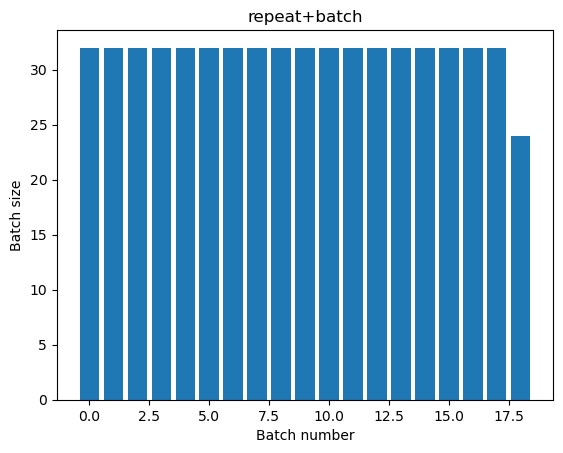

In [38]:
# plot the bar diagram of repeat+batch
repeat_batch_ds = raw_dataset.repeat(3).batch(32)
plot_batch_sizes(repeat_batch_ds,'repeat+batch')

If you need clear epoch separation, put Dataset.batch before the repeat:

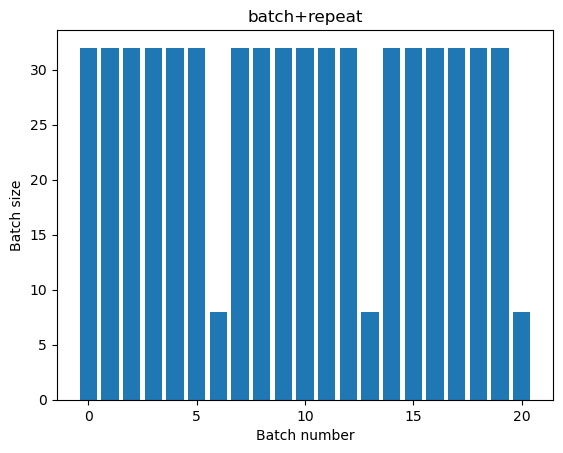

In [39]:
# plot the bar diagram of batch+repeat
batch_repeat_ds = raw_dataset.batch(32).repeat(3)
plot_batch_sizes(batch_repeat_ds,'batch+repeat')

##### shufflt+repeat / repeat+shufflt

As with Dataset.batch the order relative to Dataset.repeat matters.

Dataset.shuffle doesn't signal the end of an epoch until the shuffle buffer is empty. So a shuffle placed before a repeat will show every element of one epoch before moving to the next.

But a repeat before a shuffle mixes the epoch boundaries together.

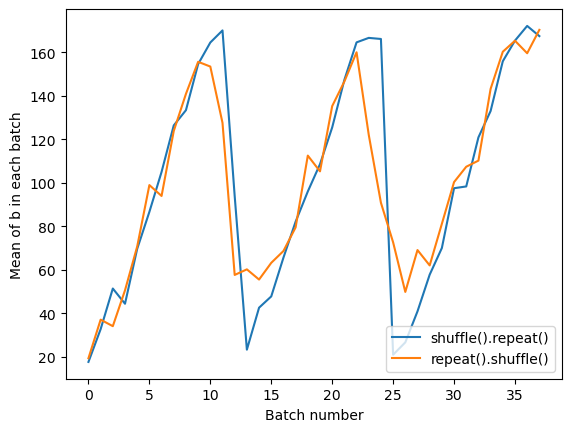

In [40]:
# You can find that a repeat before a shuffle mixes the epoch boundaries in this graph.
shuffle_repeat_ds = raw_dataset.shuffle(32).repeat(3).batch(16)
repeat_shuffle_ds = raw_dataset.repeat(3).shuffle(32).batch(16)

shuffle_repeat = [batch[1].numpy().mean() for batch in shuffle_repeat_ds]
repeat_shuffle = [batch[1].numpy().mean() for batch in repeat_shuffle_ds]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.xlabel('Batch number')
plt.ylabel("Mean of b in each batch")
plt.legend()

Now, let's start designing our cnn model!

## CNN Model for CIFAR 10

##### Loading Data Manually

To know how it works under the hood, let's load CIFAR-10 by our own (not using tf.keras). According the descripion, the dataset file is divided into five training batches and one test batch, each with 10000 image. The test batch contains exactly 1000 randomly-selected image from each class.

In [41]:
# the url to download CIFAR-10 dataset (binary version)
# see format and details here: http://www.cs.toronto.edu/~kriz/cifar.html
DATA_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
# the image size we want to keep
IMAGE_SIZE_CROPPED = 24
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_DEPTH = 3

In [42]:
# donwnload data
if not os.path.exists("cifar-10-batches-py/"): 
    cifar10 = utils.get_file('cifar-10-python.tar.gz',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = DATA_URL,
                                      extract = True)

In [43]:
DEST_DIRECTORY = 'cifar-10-batches-py'
filenames_train = [os.path.join(DEST_DIRECTORY,'data_batch_%d' % i) for i in range(1,6)]
filenames_test = [os.path.join(DEST_DIRECTORY,'test_batch')]

In [44]:
# save (img_path, label) pairs
with open('cifar10_train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filenames'])
    writer.writerows(np.array(filenames_train).reshape(-1,1))
        
with open('cifar10_test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filenames'])
    writer.writerows(np.array(filenames_test).reshape(-1,1))

In [45]:
# read data
def read_file(file):
    with open(file, 'rb') as fo:
        raw_data = pickle.load(fo, encoding='bytes')
    return raw_data[b'data'],raw_data[b'labels']

# parse training data
@tf.function
def map_fun(image,label):
    image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED)
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

# parse testing data
@tf.function
def map_fun_test(image,label):
    image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

In [46]:
X_train = None
Y_train = None
X_test = None
Y_test = None

for filename in filenames_train:
    image,label = read_file(filename)
    X_train = image if X_train is None else np.concatenate((X_train,image))
    Y_train = label if Y_train is None else np.concatenate((Y_train,label))

for filename in filenames_test:
    image,label = read_file(filename)
    X_test = image if X_test is None else np.concatenate((X_test,image))
    Y_test = label if Y_test is None else np.concatenate((Y_test,label))

# Construct training Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_train,Y_train)).map(map_fun).shuffle(10000).batch(64)

# # Construct testing Dataset
dataset_test = tf.data.Dataset.from_tensor_slices((X_test,Y_test)).map(map_fun_test).batch(64)

In [47]:
model_cifar = models.Sequential()

model_cifar.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(24, 24, 3)))
model_cifar.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar.add(layers.BatchNormalization())
                
model_cifar.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model_cifar.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar.add(layers.BatchNormalization())
                
model_cifar.add(layers.Flatten())
model_cifar.add(layers.Dense(384, activation='relu'))
model_cifar.add(layers.Dropout(0.5))
model_cifar.add(layers.Dense(192, activation='relu'))
model_cifar.add(layers.Dropout(0.5))
model_cifar.add(layers.Dense(10, activation='softmax'))

In [48]:
model_cifar.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_cifar.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        4864      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 12, 12, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 64)        102464    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                      

In [49]:
model_cifar.fit(dataset, epochs=5, validation_data=dataset_test, verbose=1)
_, test_acc = model_cifar.evaluate(dataset_test, verbose=0)
print('test accuracy:',test_acc)

Epoch 1/5
415/782 [==============>...............] - ETA: 1s - loss: 1.9553 - accuracy: 0.3174

782/782 [==============================] - 4s 3ms/step - loss: 1.7702 - accuracy: 0.3755 - val_loss: 1.3162 - val_accuracy: 0.5369
Epoch 2/5
782/782 [==============================] - 3s 3ms/step - loss: 1.3597 - accuracy: 0.5236 - val_loss: 1.1218 - val_accuracy: 0.6127
Epoch 3/5
782/782 [==============================] - 3s 3ms/step - loss: 1.1940 - accuracy: 0.5886 - val_loss: 0.9973 - val_accuracy: 0.6521
Epoch 4/5
782/782 [==============================] - 3s 3ms/step - loss: 1.0850 - accuracy: 0.6300 - val_loss: 0.9250 - val_accuracy: 0.6856
Epoch 5/5
782/782 [==============================] - 3s 3ms/step - loss: 1.0087 - accuracy: 0.6571 - val_loss: 0.8775 - val_accuracy: 0.7029
test accuracy: 0.7028999924659729


## Optimization for input pipeline

We all know that GPUs can radically reduce the time required to execute a single training step; however, all other affairs (including data loading, data transformations, memory copy from CPU to GPUs) are done by CPU, which **sometimes** becomes the bottleneck instead. We have learned above that there are lots transformations that make datasets more complex and reusable. Now, we are going to accelerate the input pipeline for better training performance, following this [guide](https://www.tensorflow.org/guide/data_performance).

The code below briefly do the same thing in [CNN Model for CIFAR 10](https://nthu-datalab.github.io/ml/labs/11-1_CNN/11-1_CNN.html#CNN-Model-for-CIFAR-10). However, we change the dataset structure to show the time comsuming during the training.

### Dataset with time

In [50]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string), # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32), # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32), # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(3072), dtype=tf.float32), # img: 32*32*3
        tf.TensorSpec(shape=(), dtype=tf.int32) # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        filenames = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------
        
        # Reading the file
        read_enter = time.perf_counter()
        imgs, label = [], []
        for filename in filenames:
            tmp_imgs, tmp_label = read_file(filename)
            imgs.append(tmp_imgs)
            label.append(tmp_label)
        imgs = tf.concat(imgs, axis=0)
        label = tf.concat(label, axis=0)
        read_elapsed = (time.perf_counter() - read_enter) / imgs.shape[0]
        
        for sample_idx in range(imgs.shape[0]):
            read_enter = read_enter if sample_idx == 0 else time.perf_counter()
            
            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                imgs[sample_idx],
                label[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

The block above defines our dataset, not only **image** and **label**, but also **steps**, **timings** and **counters**.<br>Therefore, if we take two examples:

In [51]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    filenames = rows['filenames']
    return filenames

def read_file(filename):
    with open(filename, 'rb') as fo:
        raw_data = pickle.load(fo, encoding='bytes')
    return raw_data[b'data'], raw_data[b'labels']

def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('cifar10_train.csv', open_file, read_file)

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('cifar10_test.csv', open_file, read_file)

for i in tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).take(2):
    print(i)
    print("now time", time.perf_counter())
    print("-------------------------------------------------------------------------------")

(<tf.Tensor: shape=(2, 1), dtype=string, numpy=
array([[b'Open'],
       [b'Read']], dtype=object)>, <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[5.0246294e+05, 1.5440050e-03],
       [5.0246294e+05, 2.9152386e-06]], dtype=float32)>, <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 0,  0, -1],
       [ 0,  0,  0]], dtype=int32)>, <tf.Tensor: shape=(3072,), dtype=float32, numpy=array([ 59.,  43.,  50., ..., 140.,  84.,  72.], dtype=float32)>, <tf.Tensor: shape=(), dtype=int32, numpy=6>)
now time 502463.07822053
-------------------------------------------------------------------------------
(<tf.Tensor: shape=(2, 1), dtype=string, numpy=
array([[b'Open'],
       [b'Read']], dtype=object)>, <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-1.0000000e+00, -1.0000000e+00],
       [ 5.0246306e+05,  2.9152386e-06]], dtype=float32)>, <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 0,  0, -1],
       [ 0,  0,  1]], dtype=int32)>, <tf.Tensor: shape=(3072,), dtype=f

In above, the first block shows:

- 0th instance, 0th epoch, -1th example is **Open** at 4.9066791e+05 and spend 4.5651230e-03 seconds
- 0th instance, 0th epoch, 0th example **Read** at 4.9066794e+05 and spend 2.5628499e-06 seconds
- 0th exmaple's image: [59., 43., 50., ..., 140., 84., 72.] with shape=(3072,)
- 0th example's lable: 6

The second block shows:

- 0th instance, 0th epoch, -1th example is **Open** at -1 and spend -1 seconds
- 0th instance, 0th epoch, 1th example **Read** at 4.9066806e+05 and spend 2.5628499e-06 seconds
- 1th example's image: [154., 126., 105., ..., 139., 142., 144.] with shape=(3072,)
- 1th example's lable: 9

Note that since 'cifar10_train.csv' is only opened once, only the first example is recorded **Open** time and the after examples are assigned with -1 (negative values would be filtered out). Also, the example_idx is assigned with -1, meaning that all examples are opened at the same time.

Besides, the duration of **Read** in all example are same because we calculte in average.

### Map function with time

Now, Image shape is 3072 **(=32 ⋅ 32 ⋅ 3)** and label is 0 to 1, so we have to apply map funciton to each example, meanwhile recording the time cost of map function:

In [52]:
IMAGE_SIZE_CROPPED = 24
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_DEPTH = 3

def map_decorator(func):
    def wrapper(steps, times, values, image, label):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values, image, label),
            Tout=(steps.dtype, times.dtype, values.dtype, image.dtype, tf.float32)
        )
    return wrapper

@map_decorator
def map_fun_with_time(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    # record the enter time into map_fun()
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1, 2, 0]),tf.float32),255.0)
    label = tf.one_hot(label, 10)
    distorted_image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    # distorted_image = tf.image.resize(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    # ----------------
    
    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label

@map_decorator
def map_fun_test_with_time(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    # record the enter time into map_fun_test()
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.resize(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED])
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    # ----------------
    
    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label

Note that the <span style="background-color: lightgray;">@map_decorator</span>
 in map function is necessary for record correct time. Therefore, if we take two examples again with map functions:

In [53]:
for i in tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).map(map_fun_with_time).take(2):
    print(i)
    print("now time", time.perf_counter())
    print("-------------------------------------------------------------------------------")

(<tf.Tensor: shape=(3, 1), dtype=string, numpy=
array([[b'Open'],
       [b'Read'],
       [b'Map']], dtype=object)>, <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[5.0246334e+05, 9.2307600e-04],
       [5.0246334e+05, 2.8837183e-06],
       [5.0246353e+05, 4.2494038e-01]], dtype=float32)>, <tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 1,  0, -1],
       [ 1,  0,  0],
       [ 1,  0,  0]], dtype=int32)>, <tf.Tensor: shape=(24, 24, 3), dtype=float32, numpy=
array([[[-1.1438122 , -1.4351447 , -1.5989529 ],
        [-0.97899365, -1.4351447 , -1.7820901 ],
        [-0.19155578, -0.8308271 , -1.3608761 ],
        ...,
        [ 0.50432193, -0.08000994, -0.77489424],
        [ 0.33950347, -0.28146595, -0.92139393],
        [ 0.52262384, -0.22650962, -0.77489424]],

       [[-0.75925255, -1.1421453 , -1.45247   ],
        [-0.52119267, -1.050585  , -1.5440302 ],
        [-0.0450561 , -0.6843274 , -1.3059535 ],
        ...,
        [-0.28311598, -0.7575857 , -1.141135  ],
   

After map function (and since we do not apply <span style="background-color: lightgray;">shuffle()</span>, in first block above, the image is mapped from original [59., 43., 50., ..., 140., 84., 72.] shape=(3072,) to [[[0.794585 , 0.1525154 , -0.43435538], ...]] shape=(24,24,3), the original label 6 is now mapped to [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.].

In [54]:
steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

start_time = time.perf_counter()
print("start time: ", start_time)

for steps, times, values, image, label in tqdm(tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).map(map_fun_with_time).take(10)):    
    steps_acc = tf.concat((steps_acc, steps), axis=0)
    times_acc = tf.concat((times_acc, times), axis=0)
    values_acc = tf.concat((values_acc, values), axis=0)

    # simulate training time
    train_enter = time.perf_counter()
    time.sleep(0.1)
    train_elapsed = time.perf_counter() - train_enter
    
    steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
    times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
    values_acc = tf.concat((values_acc, [values[-1]]), axis=0)

tf.print("Execution time:", time.perf_counter() - start_time)
timeline = {"steps": steps_acc, "times": times_acc, "values": values_acc}

start time:  502464.060962769


0it [00:00, ?it/s]

10it [00:01,  7.38it/s]

Execution time: 1.3848566269734874


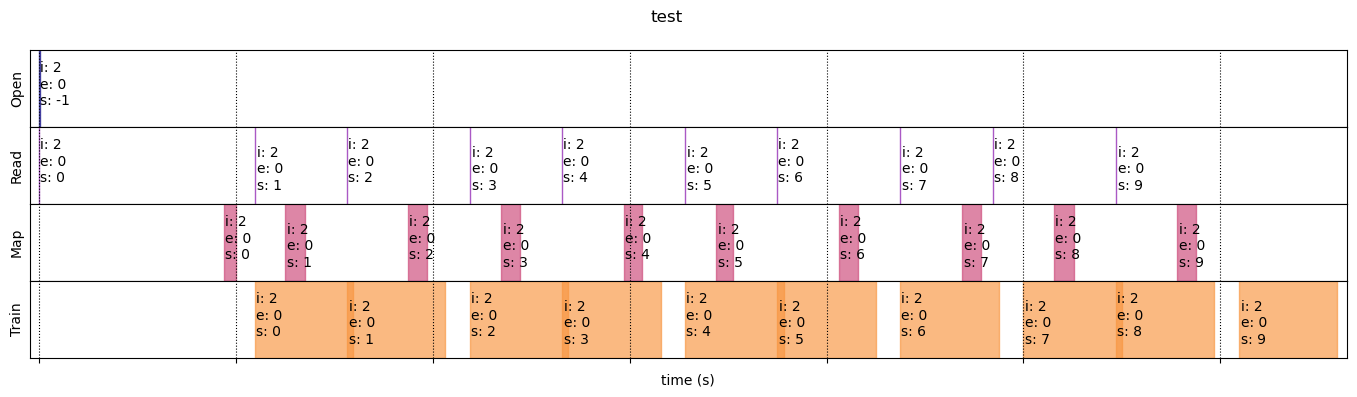

In [55]:
from lab11_1_lib import draw_timeline

draw_timeline(timeline=timeline, title="test", min_width=1, annotate=True)

or in batch:

In [56]:
steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

start_time = time.perf_counter()
print("start time: ", start_time)

for steps, times, values, image, label in tqdm(tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).map(map_fun_with_time).batch(64).take(2)):
    '''
        steps: shape=(64, 3, 1)
        times: shape=(64, 3, 2)
        vaules: shape=(64, 3, 3)
        image: shape=(64, 24, 24, 3)
        label: shape=(64, 10)
    '''
    
    steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
    times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
    values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

    train_enter = time.perf_counter()
    time.sleep(0.5) # simulate training time
    train_elapsed = time.perf_counter() - train_enter
    
    train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
    
    steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
    times_acc = tf.concat([times_acc, train_time], axis=0)
    values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

tf.print("Execution time:", time.perf_counter() - start_time)
timeline = {"steps": steps_acc, "times": times_acc, "values": values_acc}

start time:  502465.835513028


0it [00:00, ?it/s]

2it [00:10,  5.22s/it]

Execution time: 10.479265725996811


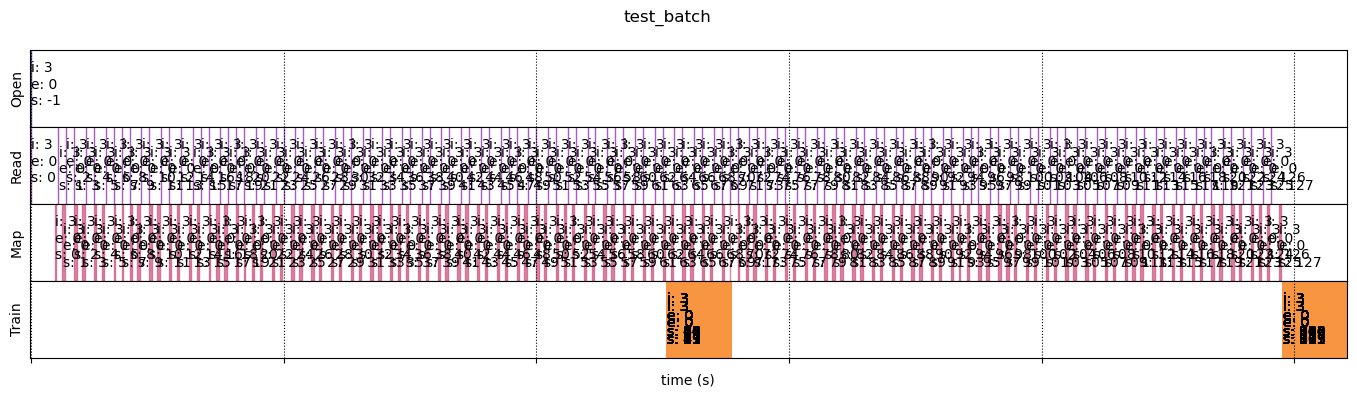

In [57]:
draw_timeline(timeline=timeline, title="test_batch", min_width=1, annotate=True)

The annotatation is quite unreadable though, we still can roughly find that example_idx in **Read**, **Map**, **Train** all run through from 0 to 127.

BTW, <span style="background-color: lightgray;">min_width</span> in <span style="background-color: lightgray;">draw_timeline()</span> indicate the minimum time duration of the graph. Since <span style="background-color: lightgray;">draw_timeline()</span> will apply <span style="background-color: lightgray;">max()</span> to <span style="background-color: lightgray;">min_width</span> and total execution time to decide the final time duration of graph, if you set a small value of <span style="background-color: lightgray;">min_width</span>, the final time duration of graph will be the total execution time.

### Re-train CNN with time

In [58]:
# re-construct a same model
model_cifar_op = models.Sequential()

model_cifar_op.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(24, 24, 3)))
model_cifar_op.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar_op.add(layers.BatchNormalization())
                
model_cifar_op.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model_cifar_op.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar_op.add(layers.BatchNormalization())
                
model_cifar_op.add(layers.Flatten())
model_cifar_op.add(layers.Dense(384, activation='relu'))
model_cifar_op.add(layers.Dropout(0.5))
model_cifar_op.add(layers.Dense(192, activation='relu'))
model_cifar_op.add(layers.Dropout(0.5))
model_cifar_op.add(layers.Dense(10, activation='softmax'))
model_cifar_op.build()
model_cifar_op.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        4864      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 12, 12, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 64)        102464    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                      

In [59]:
# save the initialization of weights 
model_cifar_op.save_weights('model_cifar_op.h5')

In [60]:
# define loss and optimizer
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [61]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = model_cifar_op(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, model_cifar_op.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_cifar_op.trainable_variables))

    train_loss(loss)
    train_accuracy(tf.argmax(label,axis=1), predictions)
    
@tf.function
def test_step(image, label):
    predictions = model_cifar_op(image, training=False)
    t_loss = loss_object(label, predictions)

    test_loss(t_loss)
    test_accuracy(tf.argmax(label,axis=1), predictions)

In [62]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(50000/BATCH_SIZE)):
            # sleep to avoid concurrency issue
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter
            
            # sleep to avoid concurrency issue
            time.sleep(0.05)
            
            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(10000/BATCH_SIZE)):
            # sleep to avoid concurrency issue
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter
            
            # sleep to avoid concurrency issue
            time.sleep(0.05)
            
            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)
            
        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

Here we only train 2 epoch since we are not pursuing performace but running experiments about better data pipeline (shorter time cost).

In [63]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# Construct training Dataset with similar steps
dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train)\
                                        .map(map_fun_with_time)\
                                        .shuffle(10000)\
                                        .batch(BATCH_SIZE, drop_remainder=True)
                                        
# Construct testing Dataset with similar steps
dataset_test = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test)\
                                       .map(map_fun_test_with_time)\
                                       .batch(BATCH_SIZE, drop_remainder=True)

timeline_Naive = timelined_benchmark(dataset_train, dataset_test, EPOCHS=2)

start time:  502477.580240609
training:


  0%|          | 0/781 [00:00<?, ?it/s]

100%|██████████| 781/781 [1:00:58<00:00,  4.68s/it] 

testing:



100%|██████████| 156/156 [10:41<00:00,  4.11s/it]

Epoch 1, Loss: 1.9053, Accuracy: 31.8702, test Loss: 1.4629, test Accuracy: 48.3073
training:



  0%|          | 0/781 [00:00<?, ?it/s]

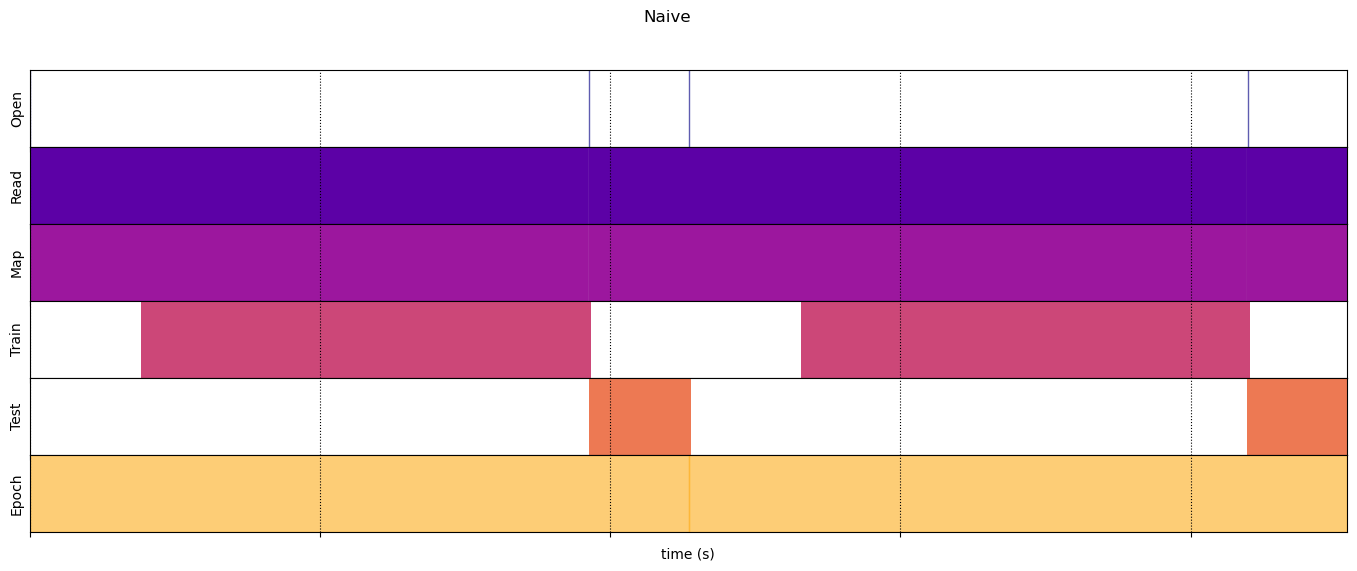

In [ ]:
draw_timeline(timeline=timeline_Naive, title="Naive", min_width=8500)

### optimization dataset pipeline

The dataset pipeline of <span style="background-color: lightgray;">(dataset_train, dataset_test)</span> is same to the [CNN Model for CIFAR 10](https://nthu-datalab.github.io/ml/labs/11-1_CNN/11-1_CNN.html#CNN-Model-for-CIFAR-10) part. However, if we optimize the pipeline as below, the performance would be better. The optimization is including:
1. [prefetching](https://www.tensorflow.org/guide/data_performance#prefetching): overlaps the preprocessing and model execution of a training step.
2. [Interleave (Parallelizing data extraction)](https://www.tensorflow.org/guide/data_performance#parallelizing_data_extraction): parallelize the data loading step, interleaving the contents of other datasets (such as data file readers).
3. [Parallel mapping](https://www.tensorflow.org/guide/data_performance#parallelizing_data_transformation): parallelized mapping across multiple CPU cores.
4. [Caching](https://www.tensorflow.org/guide/data_performance#caching): cache a dataset, save some operations (like file opening and data reading) from being executed during each epoch.
5. [Vectorizing mapping](https://www.tensorflow.org/guide/data_performance#vectorizing_mapping): batch before map, so that mapping can be vectorized.

We won't explain each of them in detail. It's recommended to study the terms above in the official documentation. Here we only demonstrate the improvement.

**Note that since we are vectorizing map function, there's one more dimension for batch in each inputs when mapping. Therefore, we have to modify map function first:**

In [ ]:
@map_decorator
def map_fun_with_time_batchwise(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0], IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    label = tf.one_hot(label, 10)
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

@map_decorator
def map_fun_test_with_time_batchwise(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)
    
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0],IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.resize(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED])
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

In [ ]:
dataset_train_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .shuffle(BUFFER_SIZE)\
                                                  .batch(BATCH_SIZE, drop_remainder=True)\
                                                  .map(map_fun_with_time_batchwise, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .cache()\
                                                  .prefetch(tf.data.AUTOTUNE)
dataset_test_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .batch(BATCH_SIZE, drop_remainder=True)\
                                                 .map(map_fun_test_with_time_batchwise, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .cache()\
                                                 .prefetch(tf.data.AUTOTUNE)

# load the same initialization of weights and re-train with optimized input pipeline
model_cifar_op.load_weights('model_cifar_op.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized, EPOCHS=2)

NameError: name 'dataset_generator_fun_train' is not defined

In [ ]:
draw_timeline(timeline_Optimized, "Optimized", min_width=8500)

In [ ]:
draw_timeline(timeline_Optimized, "Optimized", min_width=1)

From the results above, we can find that the time comsuming reduces from 8268 to 261 (sec) but get close accuracy. There's exactly no **Open**, **Read** and **Map** time consuming in 2nd epoch (which is because of the Caching). Besides, the training and testing time in 2nd epoch also decrease.

In this lab, we study how to optimize the data pipeling (I/O). The result is great though, the result is highly **depended on device**. If you re-run the exactly same code above on your device, you may get totally different result (if the bottleneck on your device is the training speed, not I/O). Besides, the data type may also affect the result. Here we read image from <span style="background-color: lightgray;">.pkl</span> files, which is an binary file with faster I/O speed. If we switch the situation like reading image from <span style="background-color: lightgray;">.jpg/.png</span> files (what you would do in the assignment below), the imporvement would be even evident.

### in practical use (a simple demo)

The code above is complicate because we have to combine time into dataset. In practical, the usage may look like:

In [ ]:
# if files have been opened and read into memory
dataset_train_example = tf.data.Dataset.from_tensor_slices((image, label))\
                                       .shuffle(BUFFER_SIZE)\
                                       .batch(BATCH_SIZE, drop_remainder=True)\
                                       .map(map_fun_batchwise, num_parallel_calls=tf.data.AUTOTUNE)\
                                       .cache()\
                                       .prefetch(tf.data.AUTOTUNE)

# or giving file path with `ImageDataGenerator()`, e.g.
flowers_file_path = tf.keras.utils.get_file('flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_image/flower_photos.tgz', untar=True)
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)
dataset_train_example = tf.data.Dataset.from_generator(
                            lambda: img_gen.flow_from_directory(flowers_file_path),
                            output_types=(tf.float32, tf.float32),
                            output_shapes=([32,256,256,3], [32,5])
                        )
dataset_train_example = dataset_train_example.shuffle(BUFFER_SIZE)\
                                             .batch(BATCH_SIZE, drop_remainder=True)\
                                             .map(map_fun_batchwise, num_parallel_calls=tf.data.AUTOTUNE)\
                                             .cache()\
                                             .prefetch(tf.data.AUTOTUNE)

# or tf.data.Dataset.list_files()
dataset_train_example = tf.data.Dataset.list_files(flowers_file_path+"/*/*.jpg")\
                                       .shuffle(BUFFER_SIZE)\
                                       .batch(BATCH_SIZE, drop_remainder=True)\
                                       .map(map_fun_batchwise, num_parallel_calls=tf.data.AUTOTUNE)\
                                       .cache()\
                                       .prefetch(tf.data.AUTOTUNE)

<span style="background-color: lightgray;">interleave()</span> is rarely used in my experience. Also remember that <span style="background-color: lightgray;">map_fun_batchwise()</span> should include <span style="background-color: lightgray;">@tf.function</span> decorator for AutoGraph speed up.